In [27]:
from skimage import feature
from functools import partial
from PIL import Image
import numpy as np
import cv2 as cv
import pandas as pd
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns

from cv_anomaly_detection.utils import MVTEC_AD, DATA_DIR
from cv_anomaly_detection.img_dataframe import ImageDataFrameMVTEC
from cv_anomaly_detection.metrics.img_metrics import measure_brightness
from cv_anomaly_detection.utils.plots import show, show_list_of_images
from cv_anomaly_detection.utils.plots import plot_multiscale_basic_features, plot_pca_cumulative_variance
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Features

for this part we will use the multiscale_basic_features from scikit-image from the article:  [Trainable segmentation using local features and random forests](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html)

In [2]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=True, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1, num_sigma=1)

In [3]:
img_df = ImageDataFrameMVTEC(category="cable")
img_df.init_default()
img_df.df

['cut_outer_insulation', 'cut_inner_insulation', 'combined', 'poke_insulation', 'good', 'missing_wire', 'missing_cable', 'cable_swap', 'bent_wire']


,image_path,width,height,dataset_type,class
0,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
1,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
2,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
3,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
4,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,train,good
...,...,...,...,...,...
369,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
370,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
371,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire
372,/home/marcelo/github.com/cv-anomaly-detection/...,1024,1024,test,bent_wire


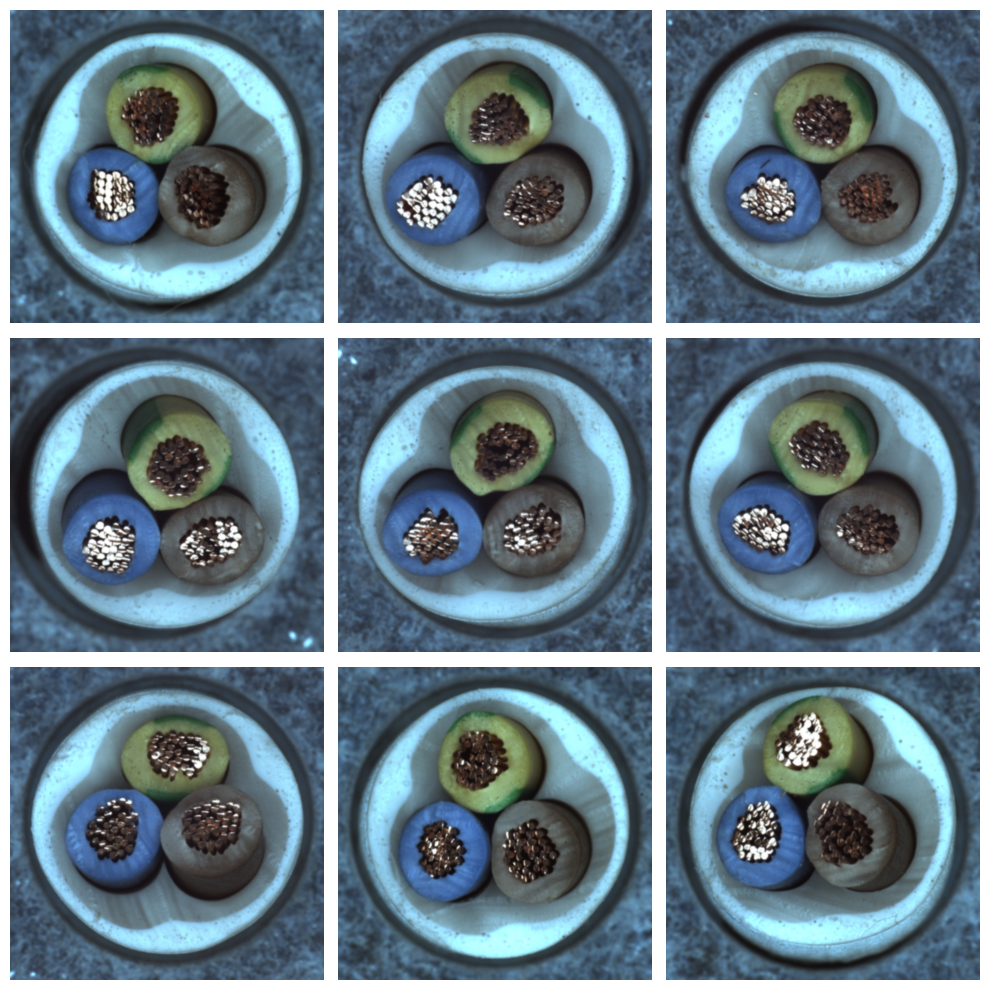

In [4]:
test_df = img_df.df[img_df.df["dataset_type"] == "test"]
test_sample = test_df[test_df["class"] == "good"].sample(n=9, replace=False)
img_arr = [Image.open(path) for path in test_sample["image_path"]]

show_list_of_images(img_arr)

In [5]:
#convert image array to numpy array
img_arr = [np.array(img) for img in img_arr]
img_0_feats = features_func(img_arr[0])

In [6]:
img_0_feats.shape

(1024, 1024, 12)

# Visualizing the features from scikit-image multiscale_basic_features

the plot below shows the features for the first image from the example array, using features like intensity, edges and texture

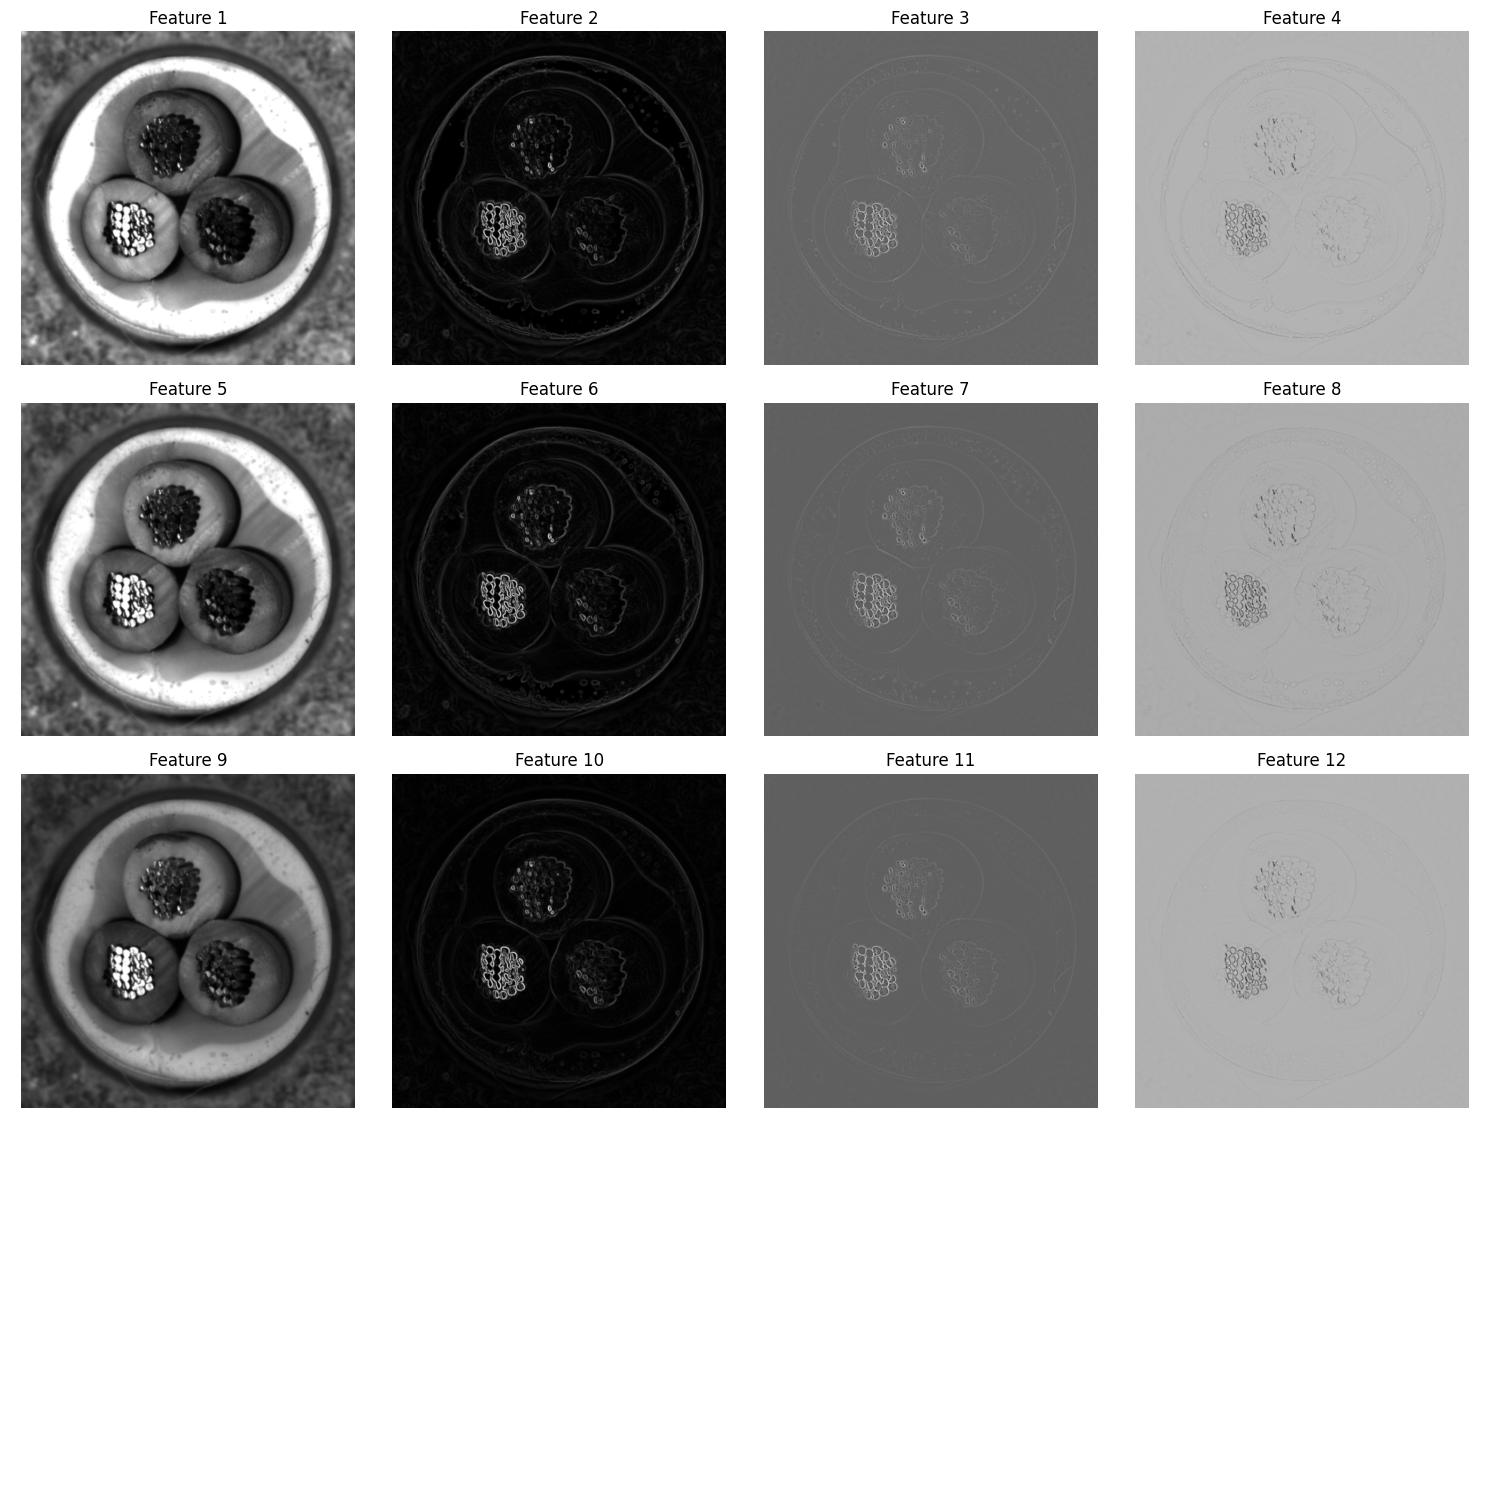

In [7]:
plot_multiscale_basic_features(img_arr[0], features_func)

the step below needed a resize since the images did not fit in RAM, some attempts could be made for example generate a csv file with the features in disk and work from it and use incremental pca

Based on Stack overflow [Incremental PCA on big data](https://stackoverflow.com/questions/31428581/incremental-pca-on-big-data) question

In [8]:
# metrics = (
#     ("multiscale_basic_features", lambda path: features_func(cv.resize(cv.imread(path), (256, 256))).flatten().tolist()),
# )
# img_df.apply_metrics(metrics) 
with h5py.File(os.path.join(DATA_DIR, 'tmp.h5'), 'w') as h5:
    flattened_feats = img_0_feats.flatten()
    
    train_df = img_df.df[img_df.df["dataset_type"] == "train"]
    rows, _ = train_df.shape
    h5.create_dataset('data', shape=(rows, flattened_feats.shape[0]), dtype=flattened_feats.dtype)
    
    for i in range(rows):
        path = train_df.iloc[i]["image_path"]
        h5["data"][i, :] = features_func(cv.imread(path)).flatten()


In [9]:
with h5py.File(os.path.join(DATA_DIR, 'tmp.h5'), 'r') as h5:
    data = h5["data"]
    
    n = data.shape[0] # how many rows we have in the dataset
    chunk_size = 16 # how many rows we feed to IPCA at a time, the divisor of n
    ipca = IncrementalPCA(n_components=16, batch_size=chunk_size)
    
    min_val = np.inf
    max_val = -np.inf
    for i in range(0, n // chunk_size, chunk_size):
        chunk = data[i*chunk_size : (i+1)*chunk_size]  # Load the chunk into memory
        min_val = min(np.min(chunk), min_val)  # Update the minimum value
        max_val = max(np.max(chunk), max_val)
        ipca.partial_fit(chunk)

print(f"Minimum value: {min_val}, Maximum value: {max_val}")

Min value: -0.2136767953634262, Max value: 1.0


# Checking the components from IncrementalPCA

In [11]:
print(ipca.components_)

[[ 8.82159366e-05  1.78588834e-05  3.37676079e-06 ...  5.38309359e-06
  -3.17557237e-07 -1.07177004e-06]
 [ 1.35971917e-04  3.36669046e-07  1.56723472e-05 ... -1.01542100e-05
   2.15251887e-07  5.33378943e-06]
 [-1.84709934e-05 -2.67250925e-05 -2.26735278e-06 ...  6.23705500e-06
  -5.53208338e-06 -2.17581965e-06]
 ...
 [ 5.41897025e-04 -7.38534652e-07  2.15210675e-05 ... -1.02659415e-05
  -2.62567187e-06  8.05592890e-07]
 [ 3.45230976e-04 -6.06221765e-05 -2.54076167e-05 ...  4.28196745e-06
  -2.74839834e-07 -3.21607172e-06]
 [ 4.62330431e-02  2.18018685e-02  3.36954258e-02 ...  5.51734614e-09
  -9.06357545e-10 -6.95307922e-10]]


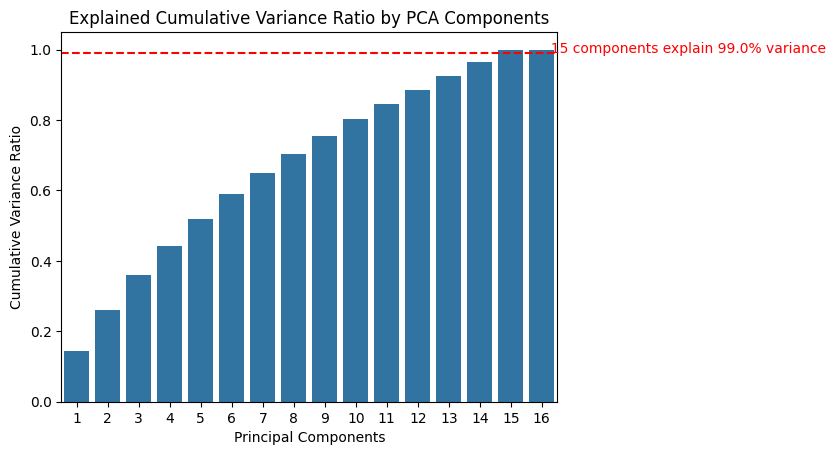

In [28]:
plot_pca_cumulative_variance(ipca, threshold=0.99)

In [25]:
cumulative_variance

array([0.14547361, 0.26179034, 0.3600111 , 0.44181612, 0.51890373,
       0.589738  , 0.6487222 , 0.7047954 , 0.7555054 , 0.8028083 ,
       0.8449961 , 0.8868098 , 0.92610425, 0.96434194, 0.99987686,
       0.99987686], dtype=float32)